## Import necessary packages tutorial

In [1]:
import renom as rm
from renom.utility.initializer import Uniform, GlorotUniform
import gym

/Users/thakur/ReNom/renom/cuda/__init__.py:12: UserWarning: Couldn't find cuda modules. No module named 'renom.cuda.cuda_base'
  warnings.warn("Couldn't find cuda modules. %s" % e)
/Users/thakur/ReNom/renom/cuda/__init__.py:29: UserWarning: Couldn't find cuda modules.
  warnings.warn("Couldn't find cuda modules.")


## Deifne the environment tutorial

In [2]:
env = gym.make('Pendulum-v0')

[2018-03-22 16:57:51,468] Making new env: Pendulum-v0


## Define the actor network tutorial

In [3]:
class Actor(rm.Model):
    
    '''Here considered 3-layer network (excluding input layer). Feel free to change the network depth 
    and check the results. The output-layer number of nuerons are equal to number of actions.
    In the example of OpenAI Gym's Pendlum-v0 environment number of actions are 1.'''
    
    def __init__(self, env, layer_size):
        self._layers = []
        self.env = env
        self.action_size = self.env.action_space.shape[0] if hasattr(self.env, "action_space") else env.action_size
        self.high = self.env.action_space.high[0] if hasattr(self.env, "action_space") else env.high
        self._l1 = rm.Dense(400, initializer=GlorotUniform())
        self._l2 = rm.Dense(300, initializer=GlorotUniform())
        self._l3 = rm.Dense(self.action_size, initializer=Uniform(min=-0.003, max=0.003))
        self._layers = [self._l1, self._l2, self._l3]
    
    def forward(self, x):
        '''Neural Network inputs are state information, outputs are actions. '''
        h1 = rm.relu(self._l1(x))
        h2 = rm.relu(self._l2(h1))
        h3 = rm.tanh(self._l3(h2)) 
        #h = self._l3(h2)
        h = h3*self.high
        return h
    
    def weigiht_decay(self):
        '''To minimize over fitting considered L2-norm (it is an optional)'''
        weight_decay = 0
        for i in range(len(self._layers)):
            weight_decay += rm.sum(self._layers[i].params.w**2)
        return weight_decay


# Define the Critic network tutorial

In [4]:
class Critic(rm.Model):
    '''Here considered a 3-layer network (input layer, hidden layer-1, hidden layer-2, output layer)
        At input-layer state information, 2nd-hidden layer actions are applied, last layer has a single neuron'''
    def __init__(self, env, layer_size):        
        self._layers = []
        self.env = env
        self._l1 = rm.Dense(layer_size[0], initializer=GlorotUniform())
        self._l2 = rm.Dense(layer_size[1], initializer=GlorotUniform())
        self._l3 = rm.Dense(1, initializer=Uniform(min=-0.003, max=0.003))
        self._layers = [self._l1, self._l2, self._l3]
  
    def forward(self, x, action):
        '''Q(s,a) calculation for a given (state, action) pair'''
        h1 = rm.relu(self._l1(x))
        h2 = rm.relu(self._l2(rm.concat(h1,action))) # actions are applied at 2nd hidden layer
        h = self._l3(h2)        
        return h
    
    def weigiht_decay(self):
        '''To minimize over fitting considered L2-norm (it is an optional)'''
        weight_decay = 0
        for i in range(len(self._layers)):
            weight_decay += rm.sum(self._layers[i].params.w**2)
        return weight_decay

## Instantiating the actor & ciritic networks 

In [5]:
from renom.algorithm.reinforcement.ddpg import DDPG
layer_size = [400, 300] # two-hidden layers dimension
actor_network = Actor(env=env,layer_size=layer_size)
critic_network = Critic(env=env, layer_size=layer_size)

## Instantiating the DDPG class

In [6]:
ddpg = DDPG(env=env, actor_network=actor_network, critic_network=critic_network)
# ddpg = DDPG(env=env) # for default

## Training 

In [7]:
[reward_list, loss_list]=ddpg.train(num_episodes=300)

episode: 000 Total reward:-1888.81 avg loss:5.9186: 100%|██████████| 200/200 [00:05<00:00, 38.48it/s]
episode: 001 Total reward:-1479.14 avg loss:0.0801: 100%|██████████| 200/200 [00:07<00:00, 25.45it/s]
episode: 002 Total reward:-1186.40 avg loss:0.0142: 100%|██████████| 200/200 [00:07<00:00, 28.36it/s]
episode: 003 Total reward:-1526.10 avg loss:0.0077: 100%|██████████| 200/200 [00:07<00:00, 22.88it/s]
episode: 004 Total reward:-1654.37 avg loss:0.0073: 100%|██████████| 200/200 [00:07<00:00, 25.89it/s]
episode: 005 Total reward:-1571.62 avg loss:0.0135: 100%|██████████| 200/200 [00:07<00:00, 30.13it/s]
episode: 006 Total reward:-1651.75 avg loss:0.0540: 100%|██████████| 200/200 [00:08<00:00, 24.68it/s]
episode: 007 Total reward:-1526.73 avg loss:0.0863: 100%|██████████| 200/200 [00:07<00:00, 25.57it/s]
episode: 008 Total reward:-1483.48 avg loss:0.0802: 100%|██████████| 200/200 [00:07<00:00, 25.29it/s]
episode: 009 Total reward:-1524.75 avg loss:0.1584: 100%|██████████| 200/200 [00:0

episode: 080 Total reward:-1492.35 avg loss:12.4661: 100%|██████████| 200/200 [00:06<00:00, 29.95it/s]
episode: 081 Total reward:-2.92 avg loss:12.7012: 100%|██████████| 200/200 [00:06<00:00, 29.82it/s]
episode: 082 Total reward:-139.74 avg loss:11.7654: 100%|██████████| 200/200 [00:06<00:00, 29.68it/s]
episode: 083 Total reward:-390.95 avg loss:10.9660: 100%|██████████| 200/200 [00:07<00:00, 26.81it/s]
episode: 084 Total reward:-675.50 avg loss:11.1654: 100%|██████████| 200/200 [00:07<00:00, 25.40it/s]
episode: 085 Total reward:-522.62 avg loss:11.4756: 100%|██████████| 200/200 [00:08<00:00, 24.85it/s]
episode: 086 Total reward:-1491.15 avg loss:14.7620: 100%|██████████| 200/200 [00:07<00:00, 27.36it/s]
episode: 087 Total reward:-421.47 avg loss:7.2278: 100%|██████████| 200/200 [00:07<00:00, 26.71it/s]
episode: 088 Total reward:-547.24 avg loss:10.3389: 100%|██████████| 200/200 [00:07<00:00, 27.22it/s]
episode: 089 Total reward:-535.04 avg loss:14.8468: 100%|██████████| 200/200 [00:07

episode: 160 Total reward:-264.42 avg loss:22.3530: 100%|██████████| 200/200 [00:06<00:00, 30.58it/s]
episode: 161 Total reward:-130.19 avg loss:13.4693: 100%|██████████| 200/200 [00:06<00:00, 30.70it/s]
episode: 162 Total reward:-121.85 avg loss:13.7930: 100%|██████████| 200/200 [00:06<00:00, 30.55it/s]
episode: 163 Total reward:-262.17 avg loss:22.3041: 100%|██████████| 200/200 [00:06<00:00, 30.39it/s]
episode: 164 Total reward:-251.80 avg loss:13.6795: 100%|██████████| 200/200 [00:06<00:00, 30.52it/s]
episode: 165 Total reward:-127.19 avg loss:16.4537: 100%|██████████| 200/200 [00:06<00:00, 30.56it/s]
episode: 166 Total reward:-241.47 avg loss:13.9016: 100%|██████████| 200/200 [00:06<00:00, 30.29it/s]
episode: 167 Total reward:-1.64 avg loss:23.3617: 100%|██████████| 200/200 [00:06<00:00, 30.54it/s]
episode: 168 Total reward:-129.66 avg loss:21.9503: 100%|██████████| 200/200 [00:06<00:00, 30.57it/s]
episode: 169 Total reward:-249.33 avg loss:13.4854: 100%|██████████| 200/200 [00:06<

episode: 240 Total reward:-240.94 avg loss:9.4152: 100%|██████████| 200/200 [00:06<00:00, 30.63it/s]
episode: 241 Total reward:-128.28 avg loss:17.4507: 100%|██████████| 200/200 [00:06<00:00, 30.42it/s]
episode: 242 Total reward:-248.18 avg loss:15.3362: 100%|██████████| 200/200 [00:06<00:00, 30.60it/s]
episode: 243 Total reward:-345.05 avg loss:11.5886: 100%|██████████| 200/200 [00:06<00:00, 30.58it/s]
episode: 244 Total reward:-2.98 avg loss:14.1987: 100%|██████████| 200/200 [00:06<00:00, 30.55it/s]
episode: 245 Total reward:-253.02 avg loss:12.1948: 100%|██████████| 200/200 [00:06<00:00, 30.35it/s]
episode: 246 Total reward:-126.92 avg loss:10.8785: 100%|██████████| 200/200 [00:06<00:00, 30.53it/s]
episode: 247 Total reward:-284.98 avg loss:13.7248: 100%|██████████| 200/200 [00:06<00:00, 30.60it/s]
episode: 248 Total reward:-130.77 avg loss:17.6414: 100%|██████████| 200/200 [00:06<00:00, 30.52it/s]
episode: 249 Total reward:-247.22 avg loss:21.8452: 100%|██████████| 200/200 [00:06<0

## Testing

In [8]:
test_reward_list = ddpg.test(render=False,episodes=10)

episode: 009 Total reward:-0.54: 100%|██████████| 200/200 [00:00<00:00, 323.53it/s]    


## Plotting the test result

Text(0,0.5,'Total Rewards per Episode')

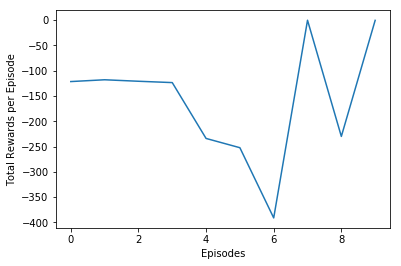

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(test_reward_list)
plt.xlabel("Episodes")
plt.ylabel("Total Rewards per Episode")